In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
site_df = pd.read_csv('data/abcd_y_lt.csv').iloc[:,[0,2,7]]
testdata = pd.read_csv('data/test.csv')
testdata = testdata[testdata.columns[~testdata.columns.str.startswith("cbcl")]]
traindata = pd.read_csv('data/train.csv')
traindata = traindata[traindata.columns[~traindata.columns.str.startswith("cbcl")]]
lostcolumns= ["interview_date","site","src_subject_id","y_t", "y_{t+1}", "eventname","race_ethnicity","urban"]
site_df['interview_date'] = pd.to_datetime(site_df['interview_date'], errors = 'coerce')
traindata['interview_date'] = pd.to_datetime(traindata['interview_date'], errors = 'coerce')
testdata['interview_date'] = pd.to_datetime(testdata['interview_date'], errors = 'coerce')
site_df['site_id_l'] = site_df['site_id_l'].str[4:].astype(int)
subject_date_site_mapping = (
    site_df.groupby('src_subject_id')
    .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))
    .to_dict()
)
def get_site(row):
    subject_id = row['src_subject_id']
    interview_date = row['interview_date']
    return subject_date_site_mapping.get(subject_id, {}).get(interview_date, None)

df_urban = pd.read_csv("data/led_l_urban.csv")
traindata['site'] = traindata.apply(get_site, axis=1)
traindata.insert(1, 'site', traindata.pop('site'))
traindata = traindata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left'  
)
traindata.insert(1, 'urban', traindata.pop('reshist_addr1_urban_area'))


testdata['site'] = traindata.apply(get_site, axis=1)
testdata.insert(1, 'site', testdata.pop('site'))  
testdata = testdata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left' 
)
testdata.insert(1, 'urban', testdata.pop('reshist_addr1_urban_area'))  

testdata = testdata.apply(pd.to_numeric,errors='coerce')

traindata = traindata.apply(pd.to_numeric,errors='coerce')

data = pd.concat([traindata, testdata], axis=0, ignore_index=True)



if data.isnull().any().any():
    data = data.fillna(0)

data['white'] = (data['race_ethnicity'] == 1).astype(int)
data['black'] = (data['race_ethnicity'] == 2).astype(int)
data['hispano'] = (data['race_ethnicity'] == 3).astype(int)
data['asian'] = (data['race_ethnicity'] == 4).astype(int)
data['others'] = (data['race_ethnicity'] == 5).astype(int)



data_mapping = {
    site: group_df for site, group_df in data.groupby('site') if site != 22
}
maxx=0
people_num =[]
for i in data_mapping:
    people_num.append(len(data_mapping[i]))
    if len(data_mapping[i])>maxx:
        maxx=len(data_mapping[i])
        largest_site_index=i

largest_site_index = [16]


traindata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter in largest_site_index], 
axis=0, 
ignore_index=True
)
data_train, hatdata = train_test_split(traindata, test_size=0.2, random_state=42)
data_test =testdata

X_train = data_train.drop(columns=lostcolumns)
feature_names = X_train.columns



top_vars = [x for x in data.columns if x not in lostcolumns]
X_train = X_train[top_vars]


y_train = data_train["y_{t+1}"]
input_dim = X_train.shape[1]
X_train = X_train.values
filtered_list = [num for num in range(1, 22) if num not in largest_site_index]


white_proportion = []
hispano_proportion = []
black_proportion = []
asian_proportion = []
other_proportion = []
for i in filtered_list:
    
    white_proportion.append(round((data_mapping[i]['race_ethnicity'] == 1).mean(),2))
    hispano_proportion.append((data_mapping[i]['race_ethnicity'] == 3).mean())
    black_proportion.append((data_mapping[i]['race_ethnicity'] == 2).mean())
    asian_proportion.append((data_mapping[i]['race_ethnicity'] == 4).mean())
    other_proportion.append((data_mapping[i]['race_ethnicity'] == 5).mean())

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

/var/folders/47/91sqyf453hs814g86jzgnwdh0000gn/T/ipykernel_10935/4127219115.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))


In [ ]:
import numpy as np
from models_MLP import TraditionalMethod, RegularizationMethod, DROMethod, tune_model_with_optuna

# Parameter configs
trad_param_ranges = {
    "hidden_dim": {"type": "int", "low": 128, "high": 192, "step": 16},
}
trad_fixed_params = {"learning_rate": 0.01, "dropout": 0.3, "num_epochs": 6000}

reg_param_ranges = {
    "hidden_dim": {"type": "int", "low": 128, "high": 192, "step": 16},
    "lambda_val": {"type": "float", "low": 1e-6, "high": 0.001, "log": True},
}
reg_fixed_params = {"learning_rate": 0.01, "dropout": 0.3, "num_epochs": 6000}

dro_param_ranges = {
    "hidden_dim": {"type": "int", "low": 128, "high": 192, "step": 32},
    "kappa": {"type": "float", "low": 1e-7, "high": 5e-5, "log": True},
}
dro_fixed_params = {
    "learning_rate": 0.01, "dropout": 0.3, "num_epochs": 6000,
    "kappacoef": 1.0, "wasserstein": 18.0
}

# Run each method
print("Tuning Traditional")
(trad_model, trad_results), trad_study = tune_model_with_optuna(
    TraditionalMethod, X_train, y_train, hatdata, top_vars, data, filtered_list,
    param_ranges=trad_param_ranges, fixed_params=trad_fixed_params, n_trials=10
)

print("Tuning Regularization")
(reg_model, reg_results), reg_study = tune_model_with_optuna(
    RegularizationMethod, X_train, y_train, hatdata, top_vars, data, filtered_list,
    param_ranges=reg_param_ranges, fixed_params=reg_fixed_params, n_trials=40
)

print("Tuning DRO")
(dro_model, dro_results), dro_study = tune_model_with_optuna(
    DROMethod, X_train, y_train, hatdata, top_vars, data, filtered_list,
    param_ranges=dro_param_ranges, fixed_params=dro_fixed_params, n_trials=60
)

print("================== Summary ==================")
print("Best Validation AUCs:")
print("Traditional:", trad_study.best_value)
print("Regularization:", reg_study.best_value)
print("DRO:", dro_study.best_value)

print("Mean AUC across sites:")
print("Traditional:", np.mean(trad_results["auc_all"]))
print("Regularization:", np.mean(reg_results["auc_all"]))
print("DRO:", np.mean(dro_results["auc_all"]))


Tuning Traditional
[Final Results Summary]
Best Validation AUC: 0.8111888586956522
Best Parameters: {'hidden_dim': 128}
Average AUC across sites: 0.7239014642266184
Tuning Regularization
[Final Results Summary]
Best Validation AUC: 0.8265217391304348
Best Parameters: {'hidden_dim': 128, 'lambda_val': 0.0005972089821633996}
Average AUC across sites: 0.7502215618822612
Tuning DRO
[Final Results Summary]
Best Validation AUC: 0.7745516304347826
Best Parameters: {'hidden_dim': 160, 'kappa': 2.321951575484618e-06}
Average AUC across sites: 0.7588971409736066
================== Summary ==================
Best Validation AUCs:
Traditional: 0.8111888586956522
Regularization: 0.8265217391304348
DRO: 0.7745516304347826
Mean AUC across sites:
Traditional: 0.7239014642266184
Regularization: 0.7502215618822612
DRO: 0.7588971409736065


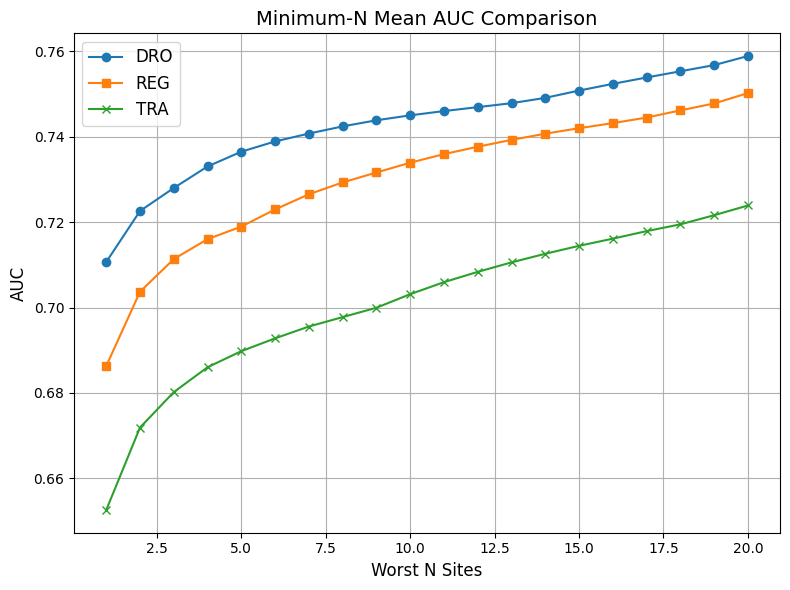

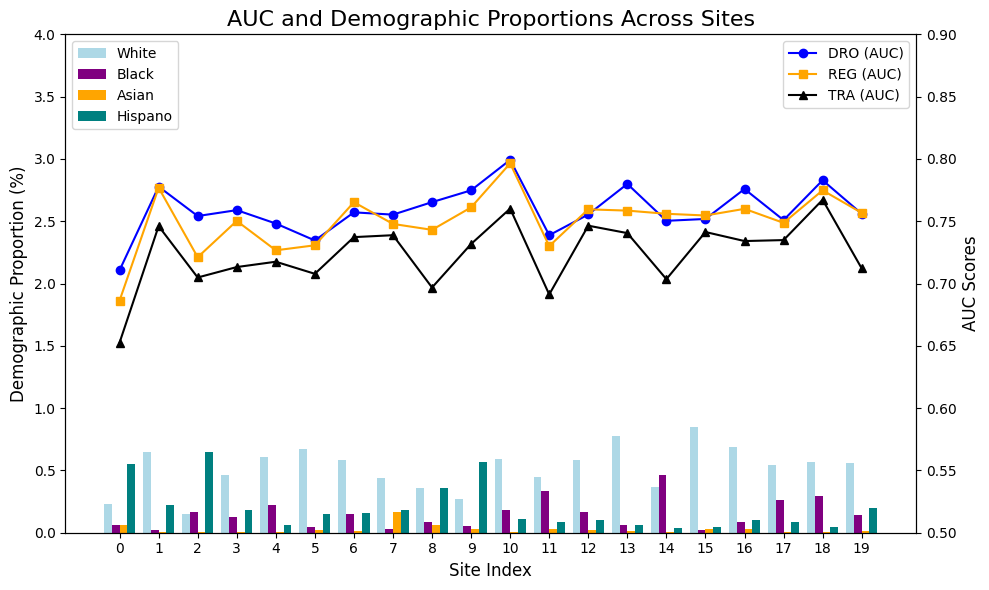

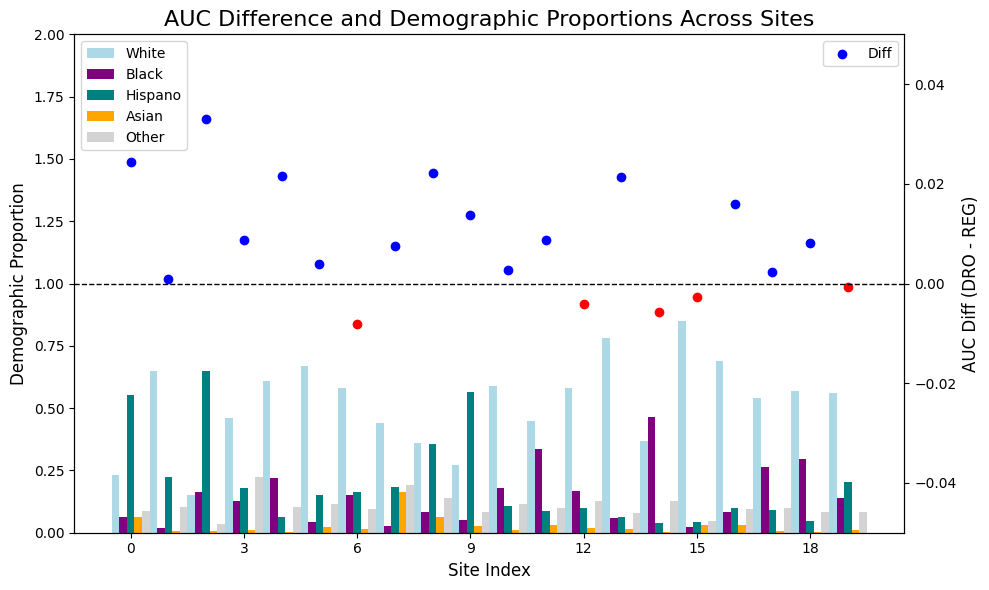


Mean's Comparison Results:
              Comparison    t_stat   p_value
0  Regularization vs DRO -3.408405  0.002948


,Comparison,t_stat,p_value
0,Regularization vs DRO,-3.408405,0.002948


In [5]:
from src.utils_plot import plot_auc_demographic_comparison
trad_auc = trad_results["auc_all"]
reg_auc = reg_results["auc_all"]
dro_auc = dro_results["auc_all"]
reg_white = reg_results["auc_non_white"]
dro_white = dro_results["auc_non_white"]
x_values = list(range(0, len(dro_auc) ))
bar_width = 0.2
color = ['lightblue', 'purple', 'teal', 'orange', 'lightgray']
plot_auc_demographic_comparison(
    trad_auc,
    reg_auc,
    dro_auc,
    reg_white,
    dro_white,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
    white_only=False  
)


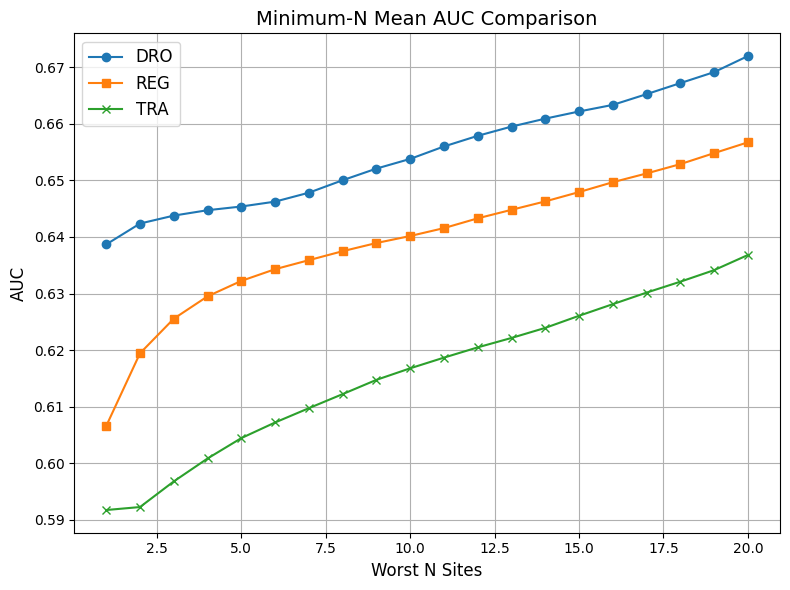

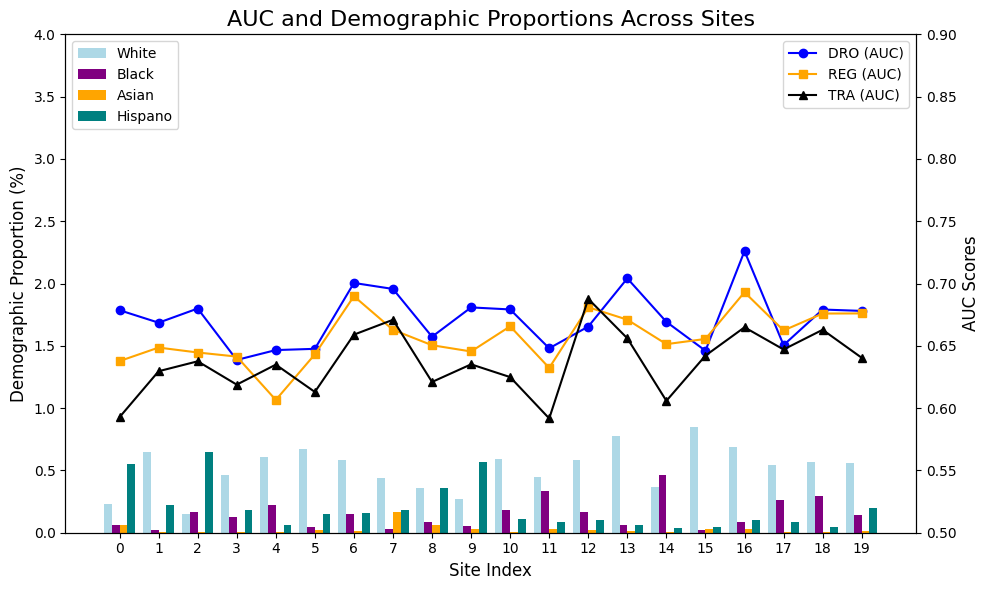

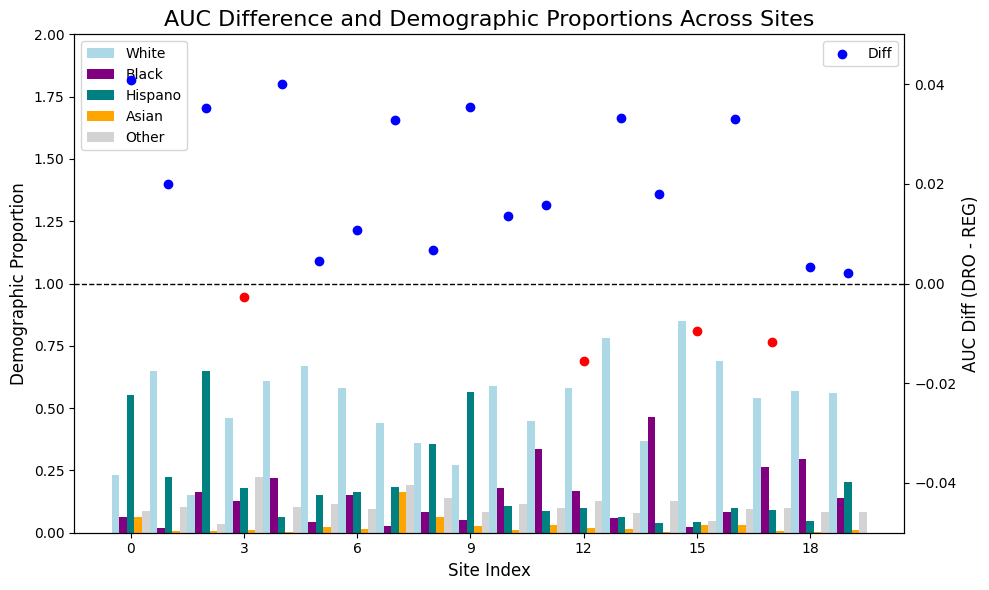


Mean's Comparison Results:
              Comparison    t_stat   p_value
0  Regularization vs DRO -3.782821  0.001258


,Comparison,t_stat,p_value
0,Regularization vs DRO,-3.782821,0.001258


In [6]:
# AUCs on sites excluding y_t == 3
trad_auc_4 = trad_results["auc_exclude_3"]
reg_auc_4 = reg_results["auc_exclude_3"]
dro_auc_4 = dro_results["auc_exclude_3"]

# AUCs on non-white group excluding y_t == 3
reg_white_4 = reg_results["auc_non_white_exclude_3"]
dro_white_4 = dro_results["auc_non_white_exclude_3"]


plot_auc_demographic_comparison(
    trad_auc_4,
    reg_auc_4,
    dro_auc_4,
    reg_white_4,
    dro_white_4,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
    white_only=False  
)

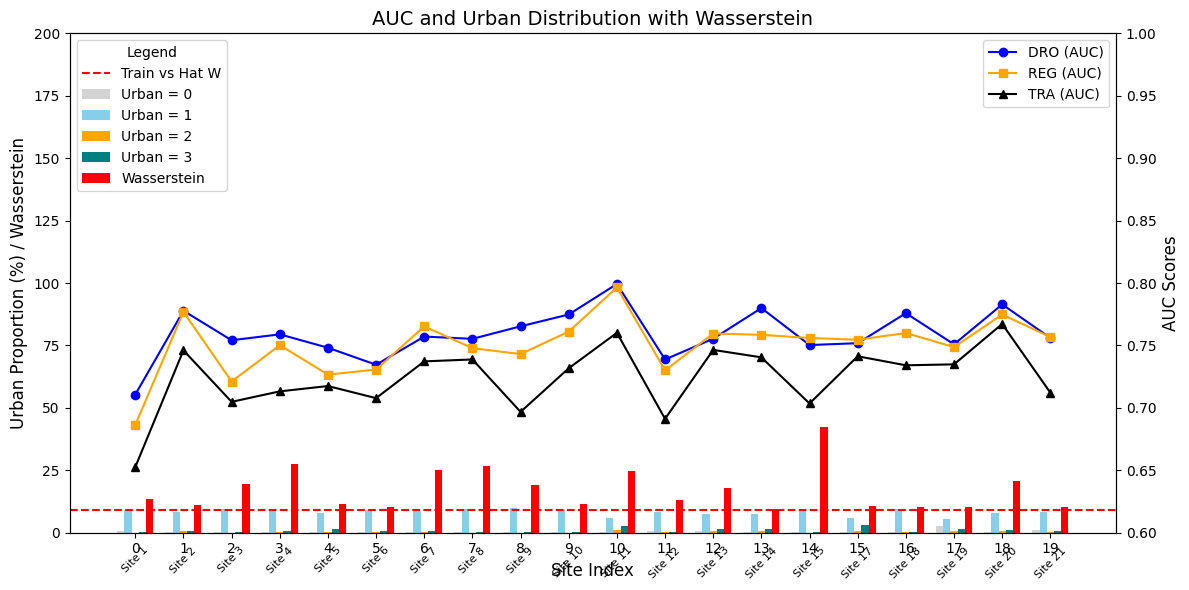

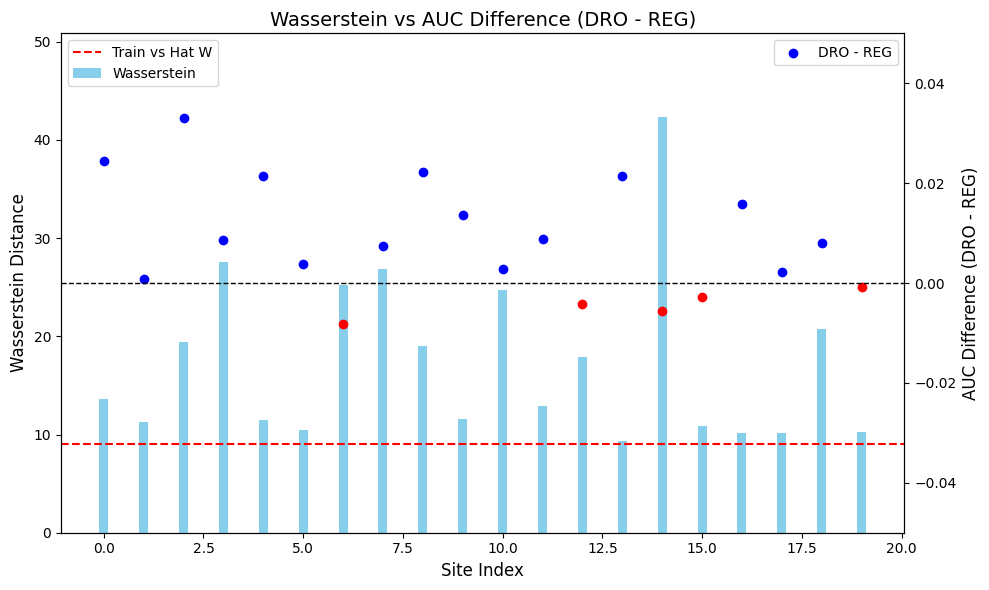


T-test Comparison Results:
                      Comparison    t_stat       p_value
0  Traditional vs Regularization -8.675052  4.930019e-08
1             Traditional vs DRO -9.479414  1.236408e-08
2          Regularization vs DRO -3.408405  2.947883e-03


In [7]:
from src.utils_plot import plot_wasserstein_and_urban_vs_auc


was_value, auc_diff, ttest_result, was_train_hat = plot_wasserstein_and_urban_vs_auc(
    data_train=data_train,
    y_train=y_train,
    data_mapping=data_mapping,
    hatdata=hatdata,
    filtered_list=filtered_list,
    top_vars=top_vars,
    trad_auc=trad_auc,
    reg_auc=reg_auc,
    dro_auc=dro_auc
)